In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 53.2 MB/s eta 0:00:00


In [3]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import gurobipy as gp
params = {
"WLSACCESSID": '',
"WLSSECRET": '',
"LICENSEID": #라이센스 ID,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2383199
Academic license - for non-commercial use only - registered to ghghgj@korea.ac.kr


In [5]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from haversine import haversine

In [19]:
## 격자 정보
candidate = pd.read_csv("/content/drive/MyDrive/캡스톤디자인/김태영/LastDance/Pmedian/count_data/final_count.csv")
candidate.head()

,id,cent_lat,cent_lon,q1_count,q2_count,q3_count,q4_count,soc_count,cand_count
0,55,35.056924,129.689788,0,0,0,0,0,1
1,215,35.101943,129.691267,0,1,0,0,0,0
2,216,35.102186,129.680311,0,2,0,0,0,0
3,217,35.102427,129.669355,0,1,0,0,0,0
4,218,35.102668,129.658399,0,3,0,0,0,0


In [20]:
candidate['sum'] =candidate['q1_count']+candidate['q2_count']+candidate['q3_count']+candidate['q4_count']

In [7]:
len(candidate)

896

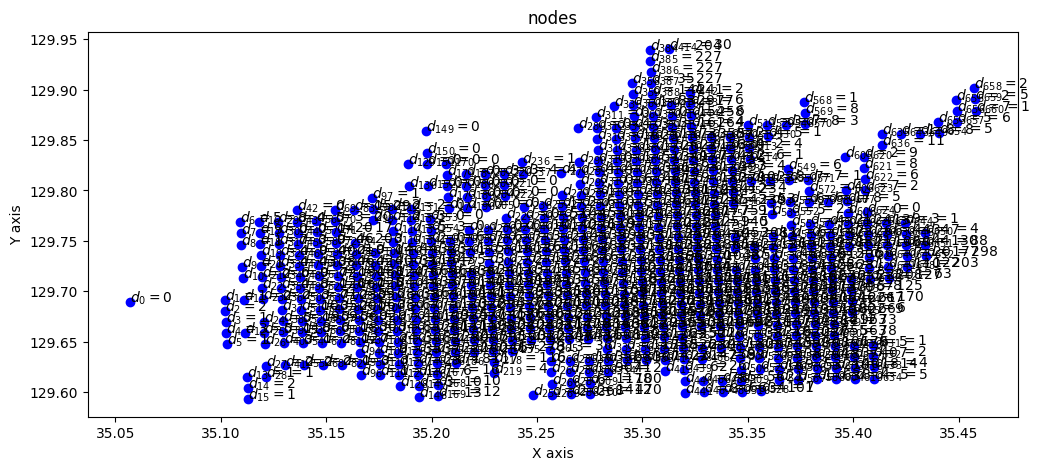

In [21]:
#노드 개수 >> 1 km 격자 단위 중심점 갯수 : QGIS 상에서 70여개 정도
N=len(candidate)

#x.y 좌표:
np.random.seed(1)
X = candidate['cent_lat'] # 중심점 위도
Y = candidate['cent_lon'] # 중심점 경도 

#수요량
demanda = candidate['sum'] # 격자 단위 bikestatus 갯수 세기
#시각화:
plt.figure(figsize=(12,5))
plt.scatter(X,Y,color='blue')

for i in range(N):
    plt.annotate('$d_{%d}=%d$'%(i, demanda[i]),(X[i],Y[i]))
    
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.title("nodes")
plt.show()

In [18]:
import folium

# 서울시 중심 위치 설정
center_lat = 37.5665
center_lon = 126.9780

# Folium 지도 객체 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
for i in range(len(X)):
    folium.Marker((X[i],Y[i])).add_to(m)
m

In [22]:
# 세트:
nodos = [i for i in range(N)]
ubicaciones = [i for i in nodos]
arcos = [(i,j) for i in nodos for j in ubicaciones]

#최대 위치 수 >> 우리는 몇개 하지? 30개 > 20개?
P=30

#거리 행렬:
distancia = {(i,j): haversine((X[i],Y[i]),(X[j],Y[j])) for i in nodos for j in ubicaciones}
#P-median
model = Model('P-Median', env=env)

#결정변수 > 위경도 좌표 반환 > 해당 좌표와 가장 근접한 BSS 후보지 찾기
x = model.addVars(arcos,vtype = GRB.BINARY, name = 'X')
y = model.addVars(ubicaciones,vtype = GRB.BINARY, name = 'Y')

#목적함수
model.setObjective(quicksum(distancia[i,j]*x[i,j] for i,j in arcos),GRB.MINIMIZE)

#제약조건
## dist(기존 BSS, point) > dist(BSS 후보지, point) : 이 제약 조건이 필요할까?
model.addConstrs (quicksum(x[i,j] for j in ubicaciones) == 1 for i in nodos)
model.addConstr(quicksum(y[j] for j in ubicaciones) <= P)
model.addConstrs(x[i,j]-y[j] <= 0 for i in nodos for j in ubicaciones)
model.optimize()
    

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to ghghgj@korea.ac.kr
Optimize a model with 437583 rows, 437582 columns and 1311424 nonzeros
Model fingerprint: 0x83e661a4
Variable types: 0 continuous, 437582 integer (437582 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve time: 9.84s
Presolved: 437583 rows, 437582 columns, 1311424 nonzeros
Variable types: 0 continuous, 437582 integer (437582 binary)
Found heuristic solution: objective 10283.998561

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.610000e+02   0.00

In [23]:
#ubicaciones Activos:
ubicaciones_activos = [k for k in ubicaciones if y[k].x > 0.9]
print(ubicaciones_activos)

[35, 40, 44, 102, 107, 127, 133, 188, 195, 200, 241, 262, 286, 317, 345, 350, 363, 381, 388, 451, 456, 483, 508, 512, 555, 572, 581, 602, 639, 653]


[(0, 35), (1, 35), (2, 35), (3, 40), (4, 40), (5, 40), (6, 44), (7, 44), (8, 44), (9, 35), (10, 35), (11, 35), (12, 40), (13, 40), (14, 40), (15, 40), (16, 44), (17, 44), (18, 44), (19, 44), (20, 35), (21, 35), (22, 35), (23, 35), (24, 40), (25, 40), (26, 40), (27, 40), (28, 40), (29, 44), (30, 44), (31, 44), (32, 44), (33, 35), (34, 35), (35, 35), (36, 35), (37, 35), (38, 40), (39, 40), (40, 40), (41, 40), (42, 44), (43, 44), (44, 44), (45, 44), (46, 44), (47, 35), (48, 35), (49, 35), (50, 35), (51, 35), (52, 40), (53, 40), (54, 40), (55, 40), (56, 44), (57, 44), (58, 44), (59, 44), (60, 35), (61, 35), (62, 35), (63, 35), (64, 35), (65, 40), (66, 40), (67, 40), (68, 40), (69, 44), (70, 44), (71, 44), (72, 44), (73, 44), (74, 102), (75, 102), (76, 102), (77, 102), (78, 107), (79, 107), (80, 107), (81, 107), (82, 127), (83, 44), (84, 102), (85, 102), (86, 102), (87, 102), (88, 102), (89, 102), (90, 107), (91, 107), (92, 107), (93, 107), (94, 107), (95, 127), (96, 127), (97, 133), (98, 1

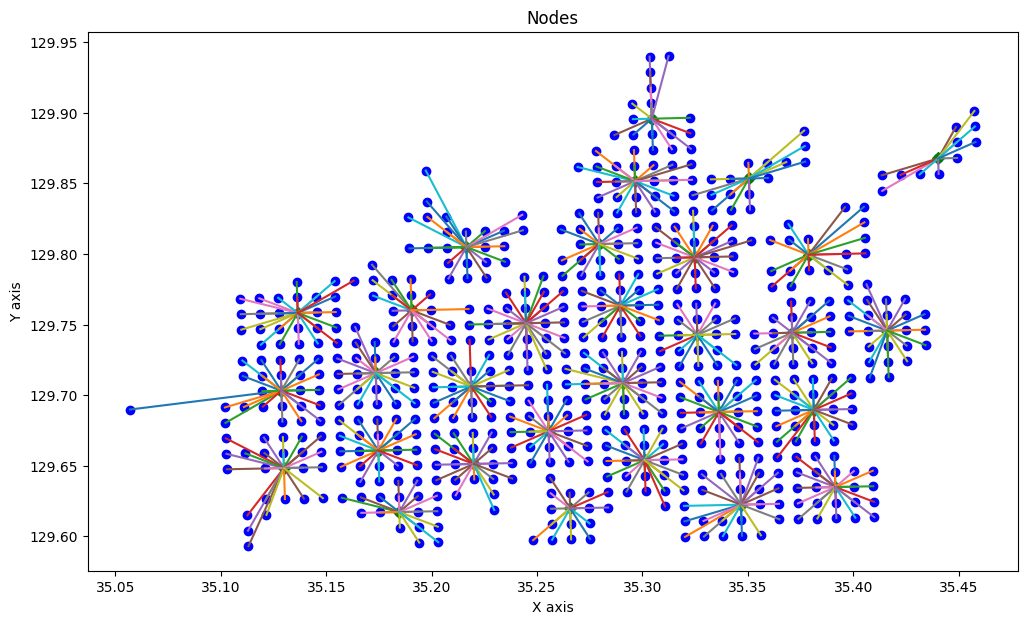

In [29]:
#ubicaciones Activos:
ubicaciones_activos = [k for k in ubicaciones if y[k].x > 0.9]
arcos_activos = [ k for k in arcos if x[k].x >0.9]
print(arcos_activos)
#Gráficar la solución
plt.figure(figsize=(12,7))
plt.scatter(X,Y,color='blue')

for n in ubicaciones_activos:
    plt.scatter (X[n],Y[n],color='green',marker='D')
    
for i in range (len(X)):
    plt.annotate('$d_{%d}=%d$'  % (i,demanda[i]),(X[i]-0.5,Y[i]-5))
    
for n in arcos_activos:
    i=n[0]
    j=n[1]
    plt.plot([X[i],X[j]],[Y[i],Y[j]])
plt.xlabel ("X axis")
plt.ylabel("Y axis")
plt.title("Nodes")
plt.show()

In [25]:
ubicaciones_activos

[35,
 40,
 44,
 102,
 107,
 127,
 133,
 188,
 195,
 200,
 241,
 262,
 286,
 317,
 345,
 350,
 363,
 381,
 388,
 451,
 456,
 483,
 508,
 512,
 555,
 572,
 581,
 602,
 639,
 653]

In [37]:
candidate.iloc[ubicaciones_activos][['cent_lat','cent_lon']]

,cent_lat,cent_lon
0,35.056924,129.689788
1,35.101943,129.691267
4,35.102668,129.658399
13,35.112626,129.614861
17,35.118471,129.757607
...,...,...
638,35.415819,129.756702
641,35.416569,129.723709
651,35.434076,129.746316
654,35.440524,129.856629


In [28]:
candidate.iloc[ubicaciones_activos][['cent_lat','cent_lon']].to_csv('/content/drive/MyDrive/캡스톤디자인/data/p_result.csv')

In [34]:
candidate

,id,cent_lat,cent_lon,q1_count,q2_count,q3_count,q4_count,soc_count,cand_count,sum
0,55,35.056924,129.689788,0,0,0,0,0,1,0
1,215,35.101943,129.691267,0,1,0,0,0,0,1
2,216,35.102186,129.680311,0,2,0,0,0,0,2
3,217,35.102427,129.669355,0,1,0,0,0,0,1
4,218,35.102668,129.658399,0,3,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
656,1447,35.449003,129.878949,0,7,0,0,0,0,7
657,1448,35.449265,129.867948,0,6,0,0,0,0,6
658,1477,35.457477,129.901274,0,2,0,0,0,0,2
659,1478,35.457741,129.890272,0,5,0,0,0,0,5


In [32]:
candidate.iloc[345]

id            881.000000
cent_lat       35.289529
cent_lon      129.763400
q1_count      166.000000
q2_count      141.000000
q3_count      171.000000
q4_count      242.000000
soc_count       3.000000
cand_count      5.000000
sum           720.000000
Name: 345, dtype: float64

In [35]:
# 세트:
nodos = [i for i in range(N)]
ubicaciones = [i for i in nodos]
arcos = [(i,j) for i in nodos for j in ubicaciones]

#최대 위치 수 >> 우리는 몇개 하지? 30개 > 20개?
P=100

#거리 행렬:
distancia = {(i,j): haversine((X[i],Y[i]),(X[j],Y[j])) for i in nodos for j in ubicaciones}
#P-median
model = Model('P-Median', env=env)

#결정변수 > 위경도 좌표 반환 > 해당 좌표와 가장 근접한 BSS 후보지 찾기
x = model.addVars(arcos,vtype = GRB.BINARY, name = 'X')
y = model.addVars(ubicaciones,vtype = GRB.BINARY, name = 'Y')

#목적함수
model.setObjective(quicksum(distancia[i,j]*x[i,j] for i,j in arcos),GRB.MINIMIZE)

#제약조건
## dist(기존 BSS, point) > dist(BSS 후보지, point) : 이 제약 조건이 필요할까?
model.addConstrs (quicksum(x[i,j] for j in ubicaciones) == 1 for i in nodos)
model.addConstr(quicksum(y[j] for j in ubicaciones) <= P)
model.addConstrs(x[i,j]-y[j] <= 0 for i in nodos for j in ubicaciones)
model.optimize()
    

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to ghghgj@korea.ac.kr
Optimize a model with 437583 rows, 437582 columns and 1311424 nonzeros
Model fingerprint: 0xfb2e5f1e
Variable types: 0 continuous, 437582 integer (437582 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve time: 11.26s
Presolved: 437583 rows, 437582 columns, 1311424 nonzeros
Variable types: 0 continuous, 437582 integer (437582 binary)
Found heuristic solution: objective 7738.6721248

Root simplex log...

Iteration    Objective       Primal Inf.    Du

[(0, 0), (1, 1), (2, 1), (3, 4), (4, 4), (5, 4), (6, 17), (7, 17), (8, 17), (9, 21), (10, 21), (11, 1), (12, 4), (13, 13), (14, 13), (15, 13), (16, 17), (17, 17), (18, 17), (19, 32), (20, 21), (21, 21), (22, 21), (23, 36), (24, 39), (25, 39), (26, 39), (27, 13), (28, 13), (29, 17), (30, 17), (31, 32), (32, 32), (33, 32), (34, 21), (35, 36), (36, 36), (37, 36), (38, 39), (39, 39), (40, 39), (41, 55), (42, 56), (43, 56), (44, 56), (45, 32), (46, 32), (47, 61), (48, 61), (49, 61), (50, 36), (51, 36), (52, 39), (53, 39), (54, 39), (55, 55), (56, 56), (57, 56), (58, 72), (59, 72), (60, 61), (61, 61), (62, 61), (63, 77), (64, 77), (65, 80), (66, 80), (67, 80), (68, 55), (69, 56), (70, 56), (71, 72), (72, 72), (73, 72), (74, 86), (75, 61), (76, 77), (77, 77), (78, 77), (79, 80), (80, 80), (81, 80), (82, 95), (83, 98), (84, 72), (85, 86), (86, 86), (87, 86), (88, 77), (89, 77), (90, 77), (91, 80), (92, 80), (93, 80), (94, 95), (95, 95), (96, 95), (97, 98), (98, 98), (99, 98), (100, 86), (101, 

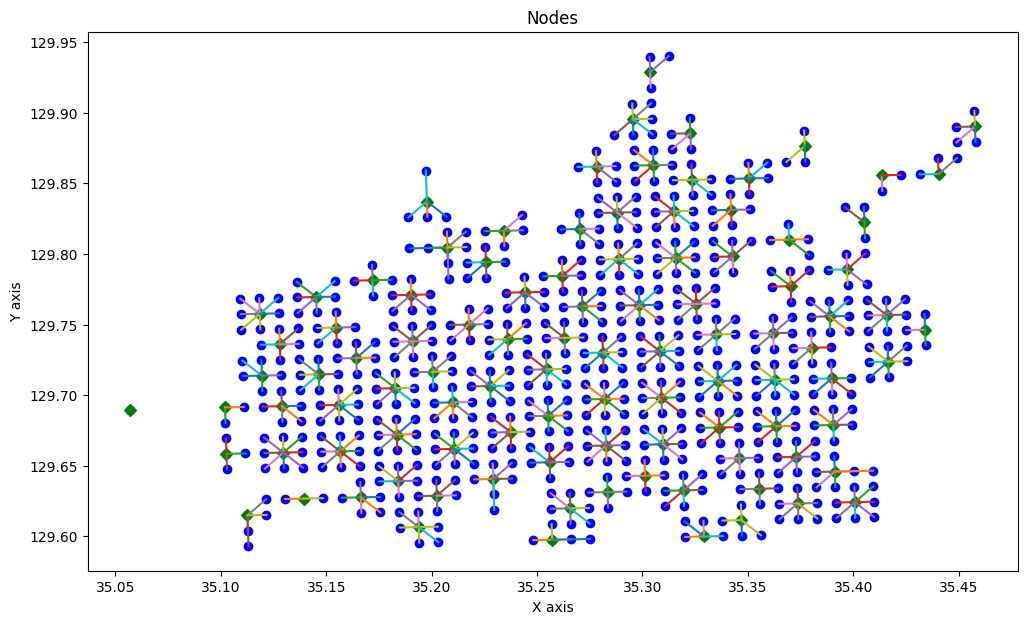

In [36]:
#ubicaciones Activos:
ubicaciones_activos = [k for k in ubicaciones if y[k].x > 0.9]
arcos_activos = [ k for k in arcos if x[k].x >0.9]
print(arcos_activos)
#Gráficar la solución
plt.figure(figsize=(12,7))
plt.scatter(X,Y,color='blue')

for n in ubicaciones_activos:
    plt.scatter (X[n],Y[n],color='green',marker='D')
    
for i in range (len(X)):
    plt.annotate('$d_{%d}=%d$'  % (i,demanda[i]),(X[i]-0.5,Y[i]-5))
    
for n in arcos_activos:
    i=n[0]
    j=n[1]
    plt.plot([X[i],X[j]],[Y[i],Y[j]])
plt.xlabel ("X axis")
plt.ylabel("Y axis")
plt.title("Nodes")
plt.show()